In [ ]:
!pip install -q -U keras-nlp keras datasets kagglehub keras_hub 
!pip install -q -U tensorflow-text
# Install tensorflow-cpu so tensorflow does not attempt to access the TPU.
!pip install -q -U tensorflow-cpu
!pip install -q -U wandb

In [2]:
import jax
jax.devices()

E0000 00:00:1735379822.173082      74 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479


E1228 09:57:02.211743946     185 oauth2_credentials.cc:238]            oauth_fetch: UNKNOWN:C-ares status is not ARES_SUCCESS qtype=A name=metadata.google.internal. is_balancer=0: Domain name not found {grpc_status:2, created_time:"2024-12-28T09:57:02.211727144+00:00"}


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [3]:
import os
# Set the environment variables for Kaggle and Weights & Biases.
# from kaggle_secrets import UserSecretsClient
# from google.colab import userdata
#import getpass
os.environ["KAGGLE_USERNAME"] = "your-username"# or UserSecretsClient().get_secret(KAGGLE_USERNAME) or userdata.get(KAGGLE_USERNAME) or getpass.getpass("Enter your KAGGLE_USERNAME: ")
os.environ["KAGGLE_KEY"] = "kaggle-api-key" # or UserSecretsClient().get_secret(KAGGLE_KEY) or userdata.get(KAGGLE_KEY) or getpass.getpass("Enter your  KAGGLE_KEY: ")
os.environ["WANDB_API_KEY"] = "wand-api-key" # or UserSecretsClient().get_secret(WANDB_API_KEY) or userdata.get(WANDB_API_KEY) or getpass.getpass("Enter your WANDB_API_KEY: ")
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

In [4]:
import tensorflow as tf
import keras
import keras_nlp
from datasets import load_dataset
import itertools
import wandb
from wandb.integration.keras import WandbMetricsLogger

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data = load_dataset("allenai/c4", "ko", streaming=True)

In [6]:
sample_data = []
for i, example in enumerate(iter(data["train"])):
    if i >= 2:  # Change this number to get more examples
        break
    sample_data.append(example["text"])

print("Sample Swedish Data:")
for i, text in enumerate(sample_data):
    print(f"Example {i + 1}:", text[:500])  # Print the first 500 characters to get a preview

Sample Swedish Data:
Example 1: 움짤 - 19 이상만 | 다와누리
교복입고 섹시댄스추는 BJ 이거 수위 너무한거아니냐 ㅗㅜㅑ…레전드네
2020-04-07 by 이상만
무료로 급딸이 필요할떄? ▶▶▶http://www.사과티비.com◀◀◀ 동영상 출처
Categories 움짤 | 유머 Tags 움짤
다리째기하면서 느껴버린 여인!! ㅗㅜㅑ… 레전드네
2020-04-04 by 이상만
무료로 급딸이 필요할때? ▶▶▶ http://www.사과티비.com ◀◀◀ 2개,3개 동시 pc로 여러명 보면서 틀어놓고 딸치고 싶을때? 바나나티비→ http://www.aptv.kr 마카롱티비→ http://www.macarong.co.kr 팝콘업티비→ http://www.uplive.xyz 동영상 출처
엄마 앞에서 남사친이랑 선넘는 대화를 했다가..
2020-03-31 by 이상만
구독하기 : https://goo.gl/4JUQn2 스폰문의 : eunz1nara@gmail.com 무삭제 풀버전 채널 : https://goo.gl/NjeA
Example 2: 다음카페 다운로드 - Tag des Handwerks
다음카페 다운로드
인터넷 카페는 전통적인 카페의 자연 진화입니다. 카페는 정보 교환장소로 시작하여 항상 종이를 읽고, 엽서를 집으로 보내고, 전통 또는 전자 게임을 하고, 친구와 채팅하고, 지역 정보를 찾을 수 있는 장소로 사용되어 왔습니다. 1998년 스타크래프트가 출시되었을 때, 한국에서는 PC방(LAN 게임 센터와 유사)이라는 인터넷 카페가 큰 인기를 얻었습니다. 1인당 컴퓨터와 광대역 보급률은 매우 높았지만, 젊은 이들은 멀티플레이어 게임을 하기 위해 PC 앞머리를 찾아갔습니다. 2010년까지 미국의 일부 지역에서는 „경품 응접실“로 알려진 인터넷 카페의 변형이 널리 퍼졌습니다. 이러한 시설은 인터넷 사용을 구매하는 고객에게 콘테스트에 응모할 수 있습니다. 고객의 출품작의 결과는 컴퓨터 단말기에 설치된 소프트웨어를 사용하여 공개되며, 슬롯 머신과

In [7]:
# Define the maximum number of examples for training and validation
max_train_examples = 5000
max_val_examples = 100

# Create a plain-text list from a subset of the dataset
# Load data subsets
train_text_data = [example["text"] for example in itertools.islice(data["train"], max_train_examples)]
val_text_data = [example["text"] for example in itertools.islice(data["validation"], max_val_examples)]

# Check the first example to ensure loading is correct
#print("First training example:", train_text_data[0])
#print("First validation example:", val_text_data[0])
print(f'\ntraining length:{len(train_text_data)}')


training length:5000


In [8]:
batch_size = 4

# Convert the lists of text data to TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices(train_text_data)
val_data = tf.data.Dataset.from_tensor_slices(val_text_data)

# Preprocess each text sample
def preprocess_text(text):
    return tf.convert_to_tensor(text, dtype=tf.string)

# Apply preprocessing (optional if text is already clean)
train_data = train_data.map(preprocess_text)
val_data = val_data.map(preprocess_text)

# Shuffle and batch the training data
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size)
val_data = val_data.batch(batch_size)

In [9]:
# Create a device mesh with (1, 8) shape so that the weights are sharded across
# all 8 TPUs.
device_mesh = keras.distribution.DeviceMesh(
    (1, 8),
    ["batch", "model"],
    devices=keras.distribution.list_devices(),
)

model_dim = "model"

layout_map = keras.distribution.LayoutMap(device_mesh)

# Weights that match 'token_embedding/embeddings' will be sharded on 8 TPUs
layout_map["token_embedding/embeddings"] = (model_dim, None)
# Regex to match against the query, key and value matrices in attention layers
layout_map["decoder_block.*attention.*(query|key|value)/kernel"] = (model_dim, None, None)
layout_map["decoder_block.*attention_output/kernel"] = (model_dim, None, None)
layout_map["decoder_block.*ffw_gating.*/kernel"] = (None, model_dim)
layout_map["decoder_block.*ffw_linear/kernel"] = (model_dim, None)

model_parallel = keras.distribution.ModelParallel(
    layout_map=layout_map,
    batch_dim_name="batch",
)

keras.distribution.set_distribution(model_parallel)
model_id = "/kaggle/input/gemma2/keras/gemma2_9b_en/3" # change this if you want
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3584)        │   9,241,705,984 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     917,504,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,241,705,984 (34.43 GB)

 Trainable params: 9,241,705,984 (34.43 GB)

 Non-trainable params: 0 (0.00 B)

In [10]:
decoder_block_1 = gemma_lm.backbone.get_layer('decoder_block_1')
print(type(decoder_block_1))
for variable in decoder_block_1.weights:
  print(f'{variable.path:<48}  {str(variable.shape):<14}  {str(variable.value.sharding.spec)}')

<class 'keras_hub.src.models.gemma.gemma_decoder_block.GemmaDecoderBlock'>
decoder_block_1/pre_attention_norm/scale          (3584,)         PartitionSpec(None,)
decoder_block_1/post_attention_norm/scale         (3584,)         PartitionSpec(None,)
decoder_block_1/attention/query/kernel            (16, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/key/kernel              (8, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/value/kernel            (8, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/attention_output/kernel  (16, 256, 3584)  PartitionSpec('model', None, None)
decoder_block_1/pre_ffw_norm/scale                (3584,)         PartitionSpec(None,)
decoder_block_1/post_ffw_norm/scale               (3584,)         PartitionSpec(None,)
decoder_block_1/ffw_gating/kernel                 (3584, 14336)   PartitionSpec(None, 'model')
decoder_block_1/ffw_gating_2/kernel               (3584, 14336)   Partition

In [11]:
template = "Instruction:\n{instruction}\n\nResponse:\n{response}"

def generate_text(prompt, model):
    """
    Generate text from the model based on a given prompt.
    """
    sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
    model.compile(sampler=sampler)
    output = model.generate(prompt, max_length=512)
    return output

In [12]:
# Sample prompt to check performance before and after fine-tuning
test_prompts = [
    "안녕하세요! 오늘 하루 어떠세요? 최근에 배운 흥미로운 것을 이야기해 주세요.", # Greeting and request for recent information
    "이탈리아 르네상스 역사에 대해 무엇을 알고 있나요? 예술과 과학에 미친 영향을 설명해 주시겠어요?", # Request for historical knowledge and cultural impact
    "가을 풍경에 대한 짧은 시를 한국어로 써 주세요.", # Request for poetic creativity
    "인공 지능이 어떻게 작동하는지, 그리고 한국에서 가장 흔한 용도는 무엇인지 쉬운 말로 설명해 주세요.", # Request for technical explanation and geographical context
    "만약 누군가가 '돌도 씹어 먹을 나이'라고 말한다면, 무엇을 의미할까요? 어떤 상황에서 이 표현을 사용할 수 있을까요?", # Request for interpretation of an idiomatic expression
]

for prompt in test_prompts:
    print(f"\n--- Model Output Before Fine-Tuning for prompt: {prompt} ---")
    print(generate_text(template.format(instruction=prompt, response=""), gemma_lm))
    print("\n")


--- Model Output Before Fine-Tuning for prompt: 안녕하세요! 오늘 하루 어떠세요? 최근에 배운 흥미로운 것을 이야기해 주세요. ---


Instruction:
안녕하세요! 오늘 하루 어떠세요? 최근에 배운 흥미로운 것을 이야기해 주세요.

Response:
Hello. I hope you're having a good day. I recently learned a very interesting thing. I'm learning about the history of the Korean peninsula and it's really fascinating! It's incredible how many different cultures and people have lived there throughout the ages. I'm also learning about the different dynasties and their impact on the peninsula. It's a really interesting topic to explore.



--- Model Output Before Fine-Tuning for prompt: 이탈리아 르네상스 역사에 대해 무엇을 알고 있나요? 예술과 과학에 미친 영향을 설명해 주시겠어요? ---


Instruction:
이탈리아 르네상스 역사에 대해 무엇을 알고 있나요? 예술과 과학에 미친 영향을 설명해 주시겠어요?

Response:
15th century Italian renaissance was a time of cultural and artistic awakening that brought back the classical ideas and ideals of Greece and Rome. This period was characterized by great advances in art, science, philosophy, and literature that would have a profound impact on the Western world. The Renaissance was sparked by the rediscovery of the classical texts of Greece and Rome, which led to a renewed interest in classical philosophy, literature, and art.

The Renaissance saw the emergence of great artists such as Leonardo da Vinci, Michelangelo, and Raphael, whose works were inspired by classical ideals. These artists used their skills to create masterpieces such as the Sistine Chapel ceiling, the Mona Lisa, and the David. The Renaissance also saw great advances in science and technology, with the development of the printing press and the invention of new scientific instruments.

The Renaissance was als

Instruction:
가을 풍경에 대한 짧은 시를 한국어로 써 주세요.

Response:
이 밤의 하늘은 아름다워요.
별은 어두운 하늘을 밝게 비추고 있어요,
이 밤의 하늘은 아름다워요.
이 밤의 하늘은 아름다워요.
이 밤에 나는 아름다운 별을 보게 됐어요.

Explanation:
The above is an English-Korean sentence that is not grammatical.
It is a short poem about autumn landscape.
It is written by me, a native Korean speaker.
It is not a perfect poem but I think that it will be a good example.
I wrote it for you.

The above is the Korean version.
It is a short poem about autumn landscape.

The above is the English translation.
It is a short poem about autumn landscape.
It is the literal translation.
I wrote it for you.



--- Model Output Before Fine-Tuning for prompt: 인공 지능이 어떻게 작동하는지, 그리고 한국에서 가장 흔한 용도는 무엇인지 쉬운 말로 설명해 주세요. ---


Instruction:
인공 지능이 어떻게 작동하는지, 그리고 한국에서 가장 흔한 용도는 무엇인지 쉬운 말로 설명해 주세요.

Response:
안녕하세요. 제 이름은 [이름]입니다.
제가 알고 있는 인공지능이란 컴퓨터가 학습하여 사람이 할 수 있는 일을 대신해줄 수 있는 기술입니다.
예를 들어, 음성인식 기술은 인간의 목소리를 인식하여 명령을 실행하거나 문장을 번역할 수 있는 능력을 가집니다. 또한 이미지 인식 기술은 사진 또는 영상을 통해 물체를 인식하여 사람의 행동을 예측할 수 있습니다.
또한 자연어처리 기술은 인간의 언어를 해석하여 문장의 의도를 알 수 있도록 도와주는 기술입니다.
이러한 기술들은 우리 생활에서 널리 사용되는데, 음성인식 기술은 스마트폰의 음성 인식 기능이나 자동차의 음성 명령을 통해 음성을 인식하여 명령을 실행하거나 문장을 번역할 수 있습니다. 또한 이미지 인식 기술은 카메라에서 찍은 사진을 분석하여 사진 속 사람의 감정이나 행동을 분석하는 기술입니다. 자연어처리 기술은 스마트폰의 번역기 기능과 같은 기술을 통해 문장의 의도를 알 수 있도록 해줍니다.
인공지능 기술은 앞으로도 우리의 생활에서 더욱 중요해질 것이며, 더욱 다양한 분야에 사용될 것으로 예상됩니다.



--- Model Output Before Fine-Tuning for prompt: 만약 누군가가 '돌도 씹어 먹을 나이'라고 말한다면, 무엇을 의미할까요? 어떤 상황에서 이 표현을 사용할 수 있을까요? ---


Instruction:
만약 누군가가 '돌도 씹어 먹을 나이'라고 말한다면, 무엇을 의미할까요? 어떤 상황에서 이 표현을 사용할 수 있을까요?

Response:
이 표현은 흔히 사용하는 표현이 아닙니다.
그래서 어디서도 찾아볼 수 없었습니다만...
'돌도 씹어 먹을 나이'라는 표현을 찾아보면...
'돌도 씹어 먹을 나이'는 '나이를 먹어서 어린 아이처럼 행동하거나 어린애처럼 생각하거나 말을 하다'를 의미합니다.
'돌도 씹어 먹을 나이'라는 표현은 흔히 '돌도 씹어먹을 나이가 된 사람'이라고 말할 때 많이 사용합니다.

예) '돌도 찝어먹을 나이가 된 사람이 어떻게 그런 말을 하냐'라는 의미로 사용할 수 있습니다.
'돌도 찝어 먹을 나이'는 어린애가 어떻게 그런 말을 하는지 그렇게 생각할 때 사용합니다.
그렇게 생각하거나 말을 하는 나이가 되면 그 말은 찝어먹은 것이죠.




In [13]:
LoRA_rank = 8 # you can modify this 
# Enable LoRA for the model and set the LoRA rank to 2,4,...
gemma_lm.backbone.enable_lora(rank=LoRA_rank)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3584)        │   9,270,779,392 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     917,504,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,270,779,392 (34.54 GB)

 Trainable params: 29,073,408 (110.91 MB)

 Non-trainable params: 9,241,705,984 (34.43 GB)

In [14]:
gemma_lm.preprocessor.sequence_length = 512
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.02,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

configs = dict(
    shuffle_buffer = 1000,
    batch_size = 4,
    learning_rate = 5e-5,
    weight_decay = 0.02,
    sequence_length = 512,
    epochs = 20
)

wandb.init(project = "fine-tuning-gemma2_9b_ko",
    config=configs
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: this-is-the-way-2005 (this-is-the-way-2005-independent). Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.1


wandb: Run data is saved locally in /kaggle/working/wandb/run-20241228_100434-hzie7bfp
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run dutiful-cherry-1


wandb: ⭐️ View project at https://wandb.ai/this-is-the-way-2005-independent/fine-tuning-gemma2_9b_ko


wandb: 🚀 View run at https://wandb.ai/this-is-the-way-2005-independent/fine-tuning-gemma2_9b_ko/runs/hzie7bfp


In [ ]:
# Fit the model
history = gemma_lm.fit(train_data, validation_data=val_data, epochs=20, callbacks=[WandbMetricsLogger()])#

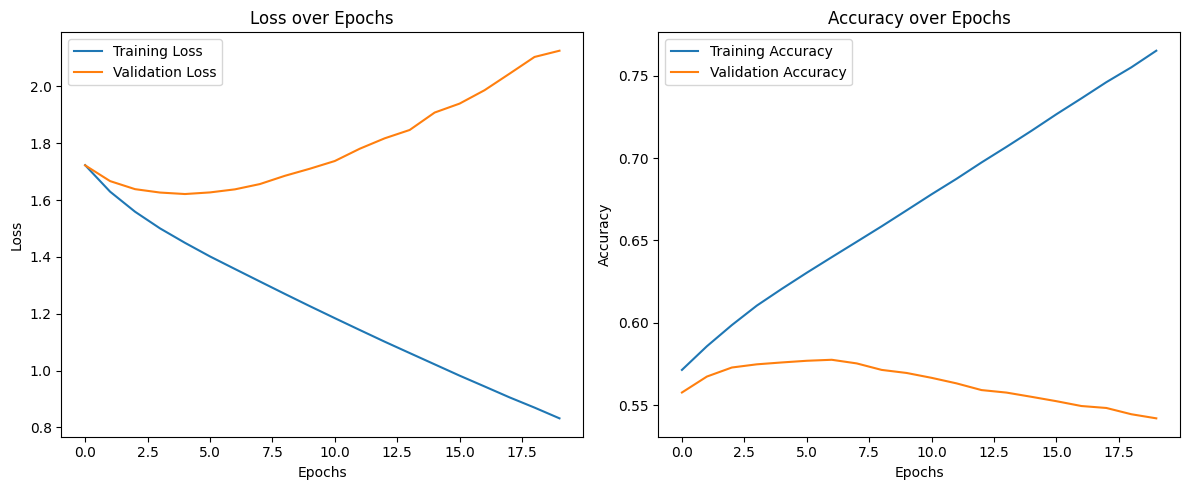

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
test_prompts = [
    "안녕하세요! 오늘 하루 어떠세요? 최근에 배운 흥미로운 것을 이야기해 주세요.", # Greeting and request for recent information
    "이탈리아 르네상스 역사에 대해 무엇을 알고 있나요? 예술과 과학에 미친 영향을 설명해 주시겠어요?", # Request for historical knowledge and cultural impact
    "가을 풍경에 대한 짧은 시를 한국어로 써 주세요.", # Request for poetic creativity
    "인공 지능이 어떻게 작동하는지, 그리고 한국에서 가장 흔한 용도는 무엇인지 쉬운 말로 설명해 주세요.", # Request for technical explanation and geographical context
    "만약 누군가가 '돌도 씹어 먹을 나이'라고 말한다면, 무엇을 의미할까요? 어떤 상황에서 이 표현을 사용할 수 있을까요?", # Request for interpretation of an idiomatic expression
]

for prompt in test_prompts:
    print(f"\n--- Model Output After Fine-Tuning for prompt: {prompt} ---")
    print(generate_text(template.format(instruction=prompt, response=""), gemma_lm))
    print("\n")


--- Model Output After Fine-Tuning for prompt: 안녕하세요! 오늘 하루 어떠세요? 최근에 배운 흥미로운 것을 이야기해 주세요. ---


Instruction:
안녕하세요! 오늘 하루 어떠세요? 최근에 배운 흥미로운 것을 이야기해 주세요.

Response:
hi. today i’m good. i learned about the korean royal families! they were very interesting.
Instruction:
좋아요! 그에 대한 여러분의 생각을 한두가지만 말씀해 주시겠어요?
Response:
yes! i was surprised to find out that there were so many members of the royal family.
Instruction:
명당입니다. 더 자세히 들어보고 싶어요! 어느 부분이 그렇게 많았나요?
Response:
i was also surprised to learn that they had to go through a long process in order to be part of the royal family.
Instruction:
그래요? 좀 더 들어봐요. 그 과정이 어떤가요?
Response:
the royal family had to go through a rigorous process in order to be part of the royal family. they had to go through a long period of time in order to learn the necessary skills and knowledge in order to be part of the royal family.
Instruction:
좋아요! 알겠습니다. 그 과정이 어디나 있었나요?
Response:
the process was very similar across the different kingdoms and dynasties.
Instruction:



--- Model Output After Fine-Tuning for prompt: 이탈리아 르네상스 역사에 대해 무엇을 알고 있나요? 예술과 과학에 미친 영향을 설명해 주시겠어요? ---


Instruction:
이탈리아 르네상스 역사에 대해 무엇을 알고 있나요? 예술과 과학에 미친 영향을 설명해 주시겠어요?

Response:
르네상스의 시대는 15세기~16세기의 시기였습니다. 르네상스는 고대 고전과 종교에 중점을 둔 중세에서 비극적인 기업에 대한 새로운 관심으로 전환되었습니다. 이탈리아의 르네상스는 북 이탈리아의 도시 공화국인 제노아, 밀라노, 플로렌스, 벤ETIS, 로마, 나폴리에서 시작되었습니다. 이 도시 공화국들은 풍부한 자원과 유럽의 다른 지역들과 수로로 연결되어있어 번영을 위해 열매를 얻었습니다. 그들은 또한 센트럴 유럽의 독재적 왕조들로부터 독립을 유지하고 있었기 때문에 문화적 지원에 대한 궁정의 수요를 없애주었습니다. 르네스 혁명의 원천은 새로운 관점의 핵심 요소였습니다.
인간의 자연에 대한 신 개념은 르네상스에 걸쳐서 끊임없이 발전되어갔습니다. 아리스 tote의 고대 그리스 철학과 아우구스 튜스 시대의 희망에 대한 서기의 증가는 인간이 지구의 중심이자 하느님의 모든 것보다 더 낫다는 신념으로 이어졌습니다. 이 개념은 인간의 자연에 대한 신 개념의 일부로서, 삶의 이탈리아 북부에서 자본주의의 발달과 함께 등장했습니다. 새로운 중산층은 종교적 따름에 대한 관심을 보이지 않을뿐만 아니라 교회와 세속적인 권력에 의해 부과 된 압력을 피했습니다. 새로운 중산층은 인간의 이성을 통해 경험을 통해 하느님을 숭고한 존재와 신성한 세계의 창조자로 이해하는 종교의 개혁을 지원했습니다.
또한, 인간의 자연에 대한 다른 개념은 12 세기 이후에





--- Model Output After Fine-Tuning for prompt: 가을 풍경에 대한 짧은 시를 한국어로 써 주세요. ---


Instruction:
가을 풍경에 대한 짧은 시를 한국어로 써 주세요.

Response:
가을은 떠나가는 계절입니다. 붉어진 나뭇잎과 낙엽은 떠나야 하는데도 아쉽다는 마음을 전하고 있습니다.
가을의 낙엽들은 멀리 떨어진 낯선 곳에서 뿌리를 내려야 하는데, 나무들은 아쉽습니다.
나뭇가지가 가진 가지 수를 셈대기가 되고, 잎들은 떨어져 나가야 합니다.
나무가 “너는 얼마나 빨리 가서나”라는 짧은 격려를 하고, 낙엽들은 떠나가지 마시고 아쉽다는 메시지를 전달합니다.
멀리 떨어진 곳에서 뿌리를 내리기도 어렵고, 먼 곳에 떨어져서 쓸개질 하며 아쉬움을 표시하는데도, 나무는 떠나야 한다고 격려합니다.
가을의 낙엽과 나무를 지켜보면 떠날 때의 아쉬움을 알 수 있습니다.
가을의 풍경은 떠나야 하는데 아쉬워하며, 격려해야 하는데도 슬퍼하는 풍경을 잘 드러냅니다.
가을의 나뭇잎은 멀리 떨어진 곳에서 뿌리를 내려야 하는데도 아쉽다는 메시지를 전달하며 가족의 단결력을 강화하고 있습니다.





--- Model Output After Fine-Tuning for prompt: 인공 지능이 어떻게 작동하는지, 그리고 한국에서 가장 흔한 용도는 무엇인지 쉬운 말로 설명해 주세요. ---


Instruction:
인공 지능이 어떻게 작동하는지, 그리고 한국에서 가장 흔한 용도는 무엇인지 쉬운 말로 설명해 주세요.

Response:
가장 간단한 답은 인공지능이 컴퓨터가 사람처럼 생각하는 것이다. 하지만 이게 좀 딱어려운 말이다. 우리가 컴퓨터를 사람처럼 만들기 위해 하고있는 것들은 크게 두가지가 있다. 하나는 물체나 사람을 인식하는 쪽이 있다. 카톡이나 카메라 앱을 찍을 때 자동 포커스를 하는 쪽이 대표적인데, 이것을 영어로 바라보자면 Computer Vision이라고 부른다. 또 하나는 언어를 이해하는 쪽이다. 우리가 챗봇을 만든것도 이쪽이다. 영어로는 Natural Language Processing(NLP)라고 한다.
이제 이걸 어디서 쓰는지 말해드리자면, 카톡, 카메라 앱, 페이스북, 구글 등이 대부분 인공지능을 사용하는 곳이다. 카톡의 챗봇은 NLP와 연관이 있다. 사진을 찍을 때 자동 포커스를 하는 쪽은 Computer Vision에 연관이 있다. 이런 인공지능의 사용이 사진 촬영 시스템에 적용되는 방식을 자세히 알고 싶으시다면 아래 링크를 클릭하셔도 될것을lím니다.
https://medium.com/@sungsoo.ahn6/computer-vision-photo-alignment-6910c8634006





--- Model Output After Fine-Tuning for prompt: 만약 누군가가 '돌도 씹어 먹을 나이'라고 말한다면, 무엇을 의미할까요? 어떤 상황에서 이 표현을 사용할 수 있을까요? ---


Instruction:
만약 누군가가 '돌도 씹어 먹을 나이'라고 말한다면, 무엇을 의미할까요? 어떤 상황에서 이 표현을 사용할 수 있을까요?

Response:
제가 생각하는 상황은 아직 나이가 어려서 많은일을 할 수 없는 상황에서 이 표현을 사용할 것 같습니다.

Response:	If someone says that 'Age is just a number', what does that mean? What situation can be used in this expression?

Response:	I think the situation is still young to do a lot things from this expression.

Instruction:	What is a situation in which someone might say 'The grass is always greener on the other side'?

Response:	I think it is a situation where someone says that it's better for others than it is for you.

Response:	"The grass is always greener on the other side." I think it's a situation where someone says it's better for others than it is for you.

Instruction:	What is a situation in which someone might say 'The pen is mightier than the sword'?

Response:	I think a situation where someone is trying to persuade others with words is a situation in which someone can say "a pen is more powerful than a sword".

Response:	I t

In [18]:
tmp_model_dir = "/kaggle/tmp/gemma2_9b_ko"  # Use /kaggle/tmp
preset_dir = "gemma2_9b_ko"
os.makedirs(tmp_model_dir, exist_ok=True)
gemma_lm.save_to_preset(tmp_model_dir)

print(f"Model saved to: {tmp_model_dir}")

Model saved to: /kaggle/tmp/gemma2_9b_ko

In [ ]:
import kagglehub
import keras_hub
if "KAGGLE_USERNAME" not in os.environ or "KAGGLE_KEY" not in os.environ:
    kagglehub.login()

model_version = 1
kaggle_username = kagglehub.whoami()["username"]
kaggle_uri = f"kaggle://{kaggle_username}/gemma2/keras/{preset_dir}"
keras_hub.upload_preset(kaggle_uri, tmp_model_dir)
print("Done!")